# 0. Chargement des données

In [2]:
########### Preparation ##############
# import packages
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [36]:
ELfriendG = nx.read_edgelist('ELfriend_edgelist.txt',comments="node",create_using=nx.DiGraph(),nodetype=int)
ELcoworkG = nx.read_edgelist('ELcowork_edgelist.txt',comments="node",create_using=nx.Graph(),nodetype=int)
ELadviceG = nx.read_edgelist('ELadvice_edgelist.txt',comments="node",create_using=nx.DiGraph(),nodetype=int)
ELnodes = pd.read_csv("ELnodeAttributes.txt", sep='\t')
ELNodeData = ELnodes.set_index('Node').to_dict('index').items()
ELfriendG.name = "ELfriend"
ELcoworkG.name = "ELcowork"
ELadviceG.name = "Eladvice"
ELfriendG.add_nodes_from(ELNodeData)
ELcoworkG.add_nodes_from(ELNodeData)
ELadviceG.add_nodes_from(ELNodeData)
print(nx.info(ELadviceG), '\n\n', nx.info(ELfriendG), '\n\n', nx.info(ELcoworkG),sep="")

Name: Eladvice
Type: DiGraph
Number of nodes: 71
Number of edges: 892
Average in degree:  12.5634
Average out degree:  12.5634

Name: ELfriend
Type: DiGraph
Number of nodes: 71
Number of edges: 575
Average in degree:   8.0986
Average out degree:   8.0986

Name: ELcowork
Type: Graph
Number of nodes: 71
Number of edges: 378
Average degree:  10.6479


In [76]:
id_lawyer = 64
print("L'individu choisi est le",id_lawyer,
      "\nSes attributs sont :", ELfriendG.nodes(data=True)[id_lawyer])
egoi_advice = nx.ego_graph(ELadviceG, id_lawyer)
egoi_friend = nx.ego_graph(ELfriendG, id_lawyer)
egoi_cowork = nx.ego_graph(ELcoworkG, id_lawyer)

L'individu choisi est le 64 
Ses attributs sont : {'Status': 2, 'Gender': 2, 'Office': 1, 'Senior': 2, 'Age': 45, 'Spec': 2, 'School': 2}


In [45]:
for e1, e2 in list(egoi_advice.edges):
    egoi_advice.edges[e1,e2]["type"]=1
for e1, e2 in list(egoi_friend.edges):
    egoi_friend.edges[e1,e2]["type"]=2
for e1, e2 in list(egoi_cowork.edges):
    egoi_cowork.edges[e1,e2]["type"]=3
LawyersMG = nx.MultiGraph(egoi_advice)
LawyersMG.add_nodes_from(list(egoi_friend.nodes(data=True)))
LawyersMG.add_nodes_from(list(egoi_cowork.nodes(data=True)))
LawyersMG.add_edges_from(list(egoi_friend.edges(data=True)))
LawyersMG.add_edges_from(list(egoi_cowork.edges(data=True)))
LawyersMG.edges(data=True)

# 1. Analyse sur la base ELadvice

In [68]:
.nodes()

NodeView((64, 2, 34, 7, 10, 13, 16, 53, 22))

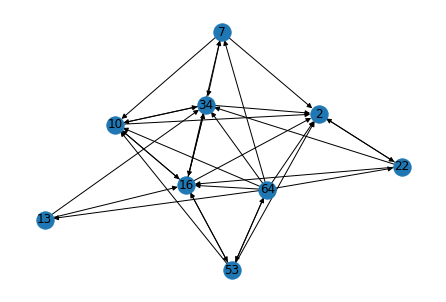

In [77]:
nx.draw_kamada_kawai(egoi_advice,with_labels=True)
plt.show()

In [57]:
list(G.edges(data=True))[1][2]['type']

1

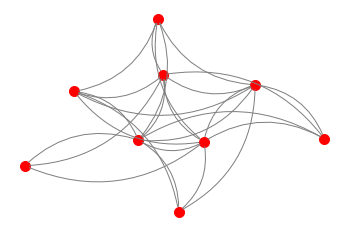

In [62]:
# Visualization

# define layout
pos = nx.kamada_kawai_layout(G)
# draw nodes according to layoabsut
nx.draw_networkx_nodes(G, pos, node_color = 'r', node_size = 100, alpha = 1)
# use matplotlib to draw edges
# on est obligé de faire une manip supplémentaire car sinon doubles edges non affichés
ax = plt.gca()
for e in G.edges(data=True):
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-",
                                color='gray',
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad={}".format(0.3*e[2]['type']),
                                ),
                )
plt.axis('off')
plt.show()

In [27]:
G

In [18]:
list(egoi_cowork.edges)

[(64, 2),
 (64, 16),
 (64, 19),
 (64, 22),
 (64, 53),
 (2, 16),
 (2, 22),
 (2, 53),
 (16, 22),
 (16, 53),
 (19, 22),
 (19, 53)]

In [16]:
egoi_cowork.edges[64,2]["type"]="test"

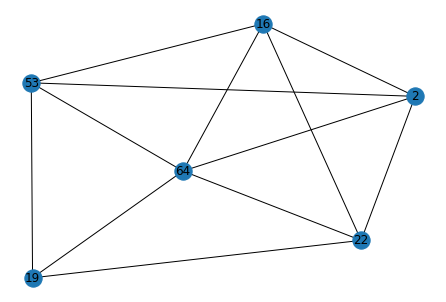

In [9]:
nx.draw_kamada_kawai(egoi_cowork,with_labels = True)

In [6]:
# use pandas to import list of nodes with attributes
nodes = pd.read_csv('Ego210_Nodes.txt', sep='\t')
print(nodes)

      ID  Qualification  Gender  Multiplexity  Support  Proximity
0    210              1       1             3        2          4
1     25              2       1             1        1          1
2     27              2       1             3        1          2
3     28              2       1             2        1          1
4     31              2       1             1        1          2
5     33              2       1             2        1          1
6     34              2       1             3        1          2
7     35              2       1             3        1          2
8     39              4       1             3        2          2
9     95              1       2             3        2          3
10   106              2       2             3        1          3
11   110              4       2             3        1          1
12   112              6       1             3        1          1
13   124              2       2             3        1          1
14   132  

In [3]:
# Let's select Ego
ego = nodes[nodes.ID==210]
print(ego)

    ID  Qualification  Gender  Multiplexity  Support  Proximity
0  210              1       1             3        2          4


In [4]:
# Select alters 
alters = nodes[nodes.ID != 210]
print(alters)

      ID  Qualification  Gender  Multiplexity  Support  Proximity
1     25              2       1             1        1          1
2     27              2       1             3        1          2
3     28              2       1             2        1          1
4     31              2       1             1        1          2
5     33              2       1             2        1          1
6     34              2       1             3        1          2
7     35              2       1             3        1          2
8     39              4       1             3        2          2
9     95              1       2             3        2          3
10   106              2       2             3        1          3
11   110              4       2             3        1          1
12   112              6       1             3        1          1
13   124              2       2             3        1          1
14   132              2       2             3        1          1
15   140  

In [7]:
# use pandas to import edgelist as a table
EgoEdges = pd.read_csv('Ego210_Edges.txt', sep=',')
EgoEdges

,V1,V2,Type
0,210,25,1
1,210,27,1
2,210,31,1
3,210,34,1
4,210,35,1
5,210,39,1
6,210,95,1
7,210,106,1
8,210,110,1
9,210,112,1


In [8]:
# generate graph from pandas edgelist
# it is an undirected multigraph
# a 'multigraph' accepts multiple types of ties (here, online and offline)

Ego210 = nx.from_pandas_edgelist(EgoEdges, 'V1', 'V2', edge_attr ='Type', create_using=nx.MultiGraph()) 
print(nx.info(Ego210))

Name: 
Type: MultiGraph
Number of nodes: 51
Number of edges: 114
Average degree:   4.4706


In [9]:
# Note: if we had created it as a simple undirected graph, networkx would have omitted multiple ties

test = nx.from_pandas_edgelist(EgoEdges, 'V1', 'V2', create_using=nx.Graph()) 
print(nx.info(test))

Name: 
Type: Graph
Number of nodes: 51
Number of edges: 71
Average degree:   2.7843


In [20]:
# match nodes of graph with attributes of nodes
NodeData = nodes.set_index('ID').to_dict('index').items()
Ego210.add_nodes_from(NodeData)

# view results
print(Ego210.nodes(data=True))

[(210, {'Qualification': 1, 'Gender': 1, 'Multiplexity': 3, 'Support': 2, 'Proximity': 4}), (25, {'Qualification': 2, 'Gender': 1, 'Multiplexity': 1, 'Support': 1, 'Proximity': 1}), (27, {'Qualification': 2, 'Gender': 1, 'Multiplexity': 3, 'Support': 1, 'Proximity': 2}), (31, {'Qualification': 2, 'Gender': 1, 'Multiplexity': 1, 'Support': 1, 'Proximity': 2}), (34, {'Qualification': 2, 'Gender': 1, 'Multiplexity': 3, 'Support': 1, 'Proximity': 2}), (35, {'Qualification': 2, 'Gender': 1, 'Multiplexity': 3, 'Support': 1, 'Proximity': 2}), (39, {'Qualification': 4, 'Gender': 1, 'Multiplexity': 3, 'Support': 2, 'Proximity': 2}), (95, {'Qualification': 1, 'Gender': 2, 'Multiplexity': 3, 'Support': 2, 'Proximity': 3}), (106, {'Qualification': 2, 'Gender': 2, 'Multiplexity': 3, 'Support': 1, 'Proximity': 3}), (110, {'Qualification': 4, 'Gender': 2, 'Multiplexity': 3, 'Support': 1, 'Proximity': 1}), (112, {'Qualification': 6, 'Gender': 1, 'Multiplexity': 3, 'Support': 1, 'Proximity': 1}), (124,

In [10]:
# view edges
print(Ego210.edges(data=True))

[(210, 25, {'Type': 1}), (210, 27, {'Type': 1}), (210, 27, {'Type': 2}), (210, 31, {'Type': 1}), (210, 34, {'Type': 1}), (210, 34, {'Type': 2}), (210, 35, {'Type': 1}), (210, 35, {'Type': 2}), (210, 39, {'Type': 1}), (210, 39, {'Type': 2}), (210, 95, {'Type': 1}), (210, 95, {'Type': 2}), (210, 106, {'Type': 1}), (210, 106, {'Type': 2}), (210, 110, {'Type': 1}), (210, 110, {'Type': 2}), (210, 112, {'Type': 1}), (210, 112, {'Type': 2}), (210, 124, {'Type': 1}), (210, 124, {'Type': 2}), (210, 132, {'Type': 1}), (210, 132, {'Type': 2}), (210, 140, {'Type': 1}), (210, 140, {'Type': 2}), (210, 260, {'Type': 1}), (210, 260, {'Type': 2}), (210, 270, {'Type': 1}), (210, 290, {'Type': 1}), (210, 317, {'Type': 1}), (210, 317, {'Type': 2}), (210, 320, {'Type': 1}), (210, 330, {'Type': 1}), (210, 330, {'Type': 2}), (210, 340, {'Type': 1}), (210, 340, {'Type': 2}), (210, 350, {'Type': 1}), (210, 350, {'Type': 2}), (210, 360, {'Type': 1}), (210, 370, {'Type': 1}), (210, 370, {'Type': 2}), (210, 410, 

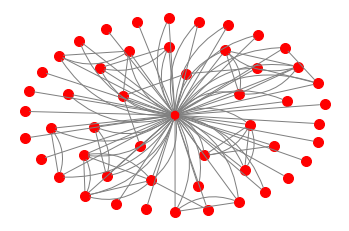

In [29]:
# Visualization

# define layout
pos = nx.kamada_kawai_layout(Ego210)
# draw nodes according to layoabsut
nx.draw_networkx_nodes(Ego210, pos, node_color = 'r', node_size = 100, alpha = 1)
# use matplotlib to draw edges
# on est obligé de faire une manip supplémentaire car sinon doubles edges non affichés
ax = plt.gca()
for e in Ego210.edges:
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-",
                                color='gray',
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad={}".format(0.3*e[2]),
                                ),
                )
plt.axis('off')
plt.show()

## Subset graph: offline-only, online-only, without Ego

In [21]:
## Subset graph: take only offline ties

# take subset of relevant edges
offline = [(u, v) for (u, v, d) in Ego210.edges(data=True) if d["Type"] ==1]

# create graph
Ego210Offline = nx.Graph(offline)
print(nx.info(Ego210Offline))

Name: 
Type: Graph
Number of nodes: 46
Number of edges: 65
Average degree:   2.8261


In [22]:
# match with nodes table to add isolates
Ego210Offline.add_nodes_from(NodeData)

# view results
print(nx.info(Ego210Offline))

Name: 
Type: Graph
Number of nodes: 51
Number of edges: 65
Average degree:   2.5490


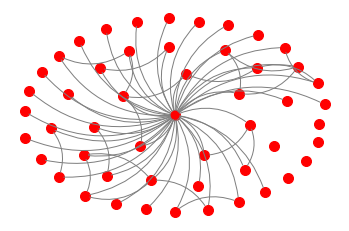

In [30]:
# Visualization

# keep the same layout as before ("pos") to compare
# draw nodes according to this layout
nx.draw_networkx_nodes(Ego210Offline, pos, node_color = 'r', node_size = 100, alpha = 1)
# use matplotlib to draw edges
ax = plt.gca()
for e in Ego210Offline.edges:
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-",
                                color='gray',
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=0.3"),
                                )
plt.axis('off')
plt.show()

##### Exercise: now, repeat the same for online ties

In [ ]:
# Graph without Ego
Ego210_noEgo = Ego210.copy()
Ego210_noEgo.remove_node(210)

In [ ]:
# View results
print(nx.info(Ego210_noEgo))

##### Exercise: now, visualize it with the same layout as Ego210

In [ ]:
## Create weighted undirected graph from multigraph
# Idea : each tie has value 2 if it is both online and offline, 1 otherwise
# We can interpret multiplexity as tie strength

Ego210WUG = nx.Graph()

for u,v,data in Ego210.edges(data=True):
    w = 1   
    if Ego210WUG.has_edge(u,v):
        Ego210WUG[u][v]['weight'] += w
    else:
        Ego210WUG.add_edge(u, v, weight=w)

print(nx.info(Ego210WUG))
print(Ego210WUG.edges(data=True))

In [ ]:
# Visualization

strongTies = [(u, v) for (u, v, d) in Ego210WUG.edges(data=True) if d["weight"] > 1]
weakTies = [(u, v) for (u, v, d) in Ego210WUG.edges(data=True) if d["weight"] <= 1]

pos = nx.spring_layout(Ego210WUG)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(Ego210WUG, pos, node_color = 'r', node_size = 100, alpha = 1)

# edges
nx.draw_networkx_edges(Ego210WUG, pos, edgelist=strongTies, width=5)  # strong ties
nx.draw_networkx_edges(Ego210WUG, pos, edgelist=weakTies, width=2) # weak ties


## Personal network composition indicators

In [ ]:
## Blau index

# recall it is equal to 1 - p1^2 - p2^2 - ... - pk^2

# first create a function
def blau(df, col):
    return (1- ((df[col].value_counts() / df[col].count()) ** 2).sum())

# then apply it to the 'alters' table, attribute 'Qualification'
blau(alters, 'Qualification')

In [ ]:
# Index of Qualitative Variation
# equal to Blau * k/(k-1)
# (normalized version)

blau(alters, 'Qualification')*6/5

In [ ]:
# NB if you need to see how many/ which categories are represented in a categorical variables
print (alters['Qualification'].unique())

In [ ]:
# Herfindahl-Hirschman index (HHI)
# equal to 1 - Blau

1 - blau(alters, 'Qualification')

#### Exercise: calculate these indexes for the other attributes (Gender, Multiplexity, Support and Proximity)

## Structural measures

In [ ]:
# find isolates (components consisting in 1 node, for example in the offline-only network)
list(nx.isolates(Ego210Offline)) 

In [ ]:
# density (for ex. in the original Ego210 graph)
nx.density(Ego210) 

In [ ]:
# Transitivity (cannot do it in Ego210 because not implemented for MultiGraph type)
print(nx.transitivity(Ego210WUG)) 

##### In principle, all structural measures can be calculated on a personal / ego network. Just be aware of graph type and relevance of each measure (par ex. reciprocity is not meaningful in un undirected graph).

## Exercises for next week

##### Take the advice network of Lazega's lawyers.

##### Extract the ego-centred network of one of the lawyers i (i = 1,..., 71).
###### NB The networkx function to extract the ego graph of i is: Egoi = nx.ego_graph(G, i)

##### Describe the ego-network of lawyer i through composition indicators (Blau index etc.) for relevant attributes, and structure indicators (density etc.).

##### Bonus: repeat the exercise with the multigraph that results from combining advice, friendship and cowork.

##### Please email to paola.tubaro@lri.fr by Tuesday, March 2, 2pm.
